In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

file_url = 'https://raw.githubusercontent.com/YufanPeter/EPL_Analysis/refs/heads/main/EPL_fyp.csv'

df = pd.read_csv(file_url)

In [ ]:
def has_complementary_record(row, df):
    if row['Venue'] == 'Away':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Home')
        ]
    elif row['Venue'] == 'Home':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Away')
        ]
    else:
        return False

    return not match.empty

df['has_match'] = df.apply(lambda row: has_complementary_record(row, df), axis=1)

if df['has_match'].all():
    print("All matched!")
else:
    missing_matches = df[~df['has_match']]
    print("Lack of data")
    print(missing_matches)

All matched!


In [ ]:
df_home = df[(df['Venue'] == 'Home') & (df['has_match'])].copy()
df_away = df[(df['Venue'] == 'Away') & (df['has_match'])].copy()

matched_pairs = []
used_away = set()

for home_index, home_row in df_home.iterrows():
    away = df_away[
        (df_away['Season'] == home_row['Season']) &
        (df_away['Team'] == home_row['Opponent']) &
        (df_away['Opponent'] == home_row['Team']) &
        (~df_away.index.isin(used_away))
    ]

    if not away.empty:
        away_index = away.index[0]
        matched_pairs.append((home_index, away_index))
        used_away.add(away_index)

count = 0
for home_idx, away_idx in matched_pairs:
    home_referee = df.loc[home_idx, 'Referee']
    away_referee = df.loc[away_idx, 'Referee']
    if home_referee == away_referee:
        count += 1

print("Number of matched pairs with the same referee:", count)

Number of matched pairs with the same referee: 3800


In [ ]:
df['LocalRef'] = (df['Team Detailed Region'] == df['Referee Hometown']).astype(int)
df['is_win'] = (df['Result'] == 'W').astype(int)

In [ ]:
win_df = df.copy()
referee_stats = {}

for home_idx, away_idx in matched_pairs:
    home_record = win_df.loc[home_idx]
    away_record = win_df.loc[away_idx]

    referee = home_record['Referee']
    referee_region = home_record['Referee Hometown']

    ref_team = None
    if (home_record['Team Detailed Region'] == referee_region) and (away_record['Team Detailed Region'] != referee_region):
        ref_team = home_record
    elif (away_record['Team Detailed Region'] == referee_region) and (home_record['Team Detailed Region'] != referee_region):
        ref_team = away_record

    if ref_team is None:
        continue

    if referee not in referee_stats:
        referee_stats[referee] = {'matches': 0, 'wins': 0}

    referee_stats[referee]['matches'] += 1
    if ref_team['Result'] == 'W':
        referee_stats[referee]['wins'] += 1

stats_info = []
for ref, stats in referee_stats.items():
    matches = stats['matches']
    wins = stats['wins']
    win_rate = round(wins / matches, 2) if matches > 0 else 0
    stats_info.append({
        'Referee': ref,
        'Wins': wins,
        'Matches': matches,
        'Win Rate': win_rate,
    })

stats_df = pd.DataFrame(stats_info)
stats_df = stats_df.sort_values(by='Wins', ascending=False)

print(stats_df[['Referee', 'Wins', 'Matches', 'Win Rate']].to_string(index=False))

          Referee  Wins  Matches  Win Rate
   Anthony Taylor    34       62      0.55
     Paul Tierney    30       41      0.73
        Lee Mason    17       24      0.71
   Chris Kavanagh    14       21      0.67
       Roger East    10       29      0.34
     Graham Scott     9       35      0.26
        Mike Dean     9       16      0.56
      David Coote     7       11      0.64
      Lee Probert     5       17      0.29
     Simon Hooper     4       26      0.15
       Mike Jones     4        7      0.57
   Andre Marriner     3       10      0.30
   Stuart Attwell     3       12      0.25
     Kevin Friend     3       10      0.30
      Darren Bond     1        2      0.50
     Tim Robinson     1        6      0.17
   Samuel Allison     1        1      1.00
      John Brooks     1        2      0.50
      Philip Dowd     1        3      0.33
      Lewis Smith     0        1      0.00
      Andy Madley     0        2      0.00
Michael Salisbury     0        1      0.00
     Joshua

In [ ]:
non_local_matches = []

for home_idx, away_idx in matched_pairs:
    home_record = win_df.loc[home_idx]
    away_record = win_df.loc[away_idx]

    referee_region = home_record['Referee Hometown']

    if (home_record['Team Detailed Region'] != referee_region) and (away_record['Team Detailed Region'] != referee_region):
        non_local_matches.append((home_idx, away_idx))

referee_nonlocal_stats = {}

for home_idx, away_idx in non_local_matches:
    home_record = win_df.loc[home_idx]
    referee = home_record['Referee']

    if referee not in referee_nonlocal_stats:
        referee_nonlocal_stats[referee] = {'matches': 0, 'wins': 0}

    referee_nonlocal_stats[referee]['matches'] += 1
    if home_record['Result'] == 'W':
        referee_nonlocal_stats[referee]['wins'] += 1

nonlocal_stats_info = []

for ref, stats in referee_nonlocal_stats.items():
    matches = stats['matches']
    wins = stats['wins']
    win_rate = round(wins / matches, 2) if matches > 0 else 0
    nonlocal_stats_info.append({
        'Referee': ref,
        'Wins': wins,
        'Matches': matches,
        'Win Rate': win_rate,
    })

nonlocal_stats_df = pd.DataFrame(nonlocal_stats_info)
nonlocal_stats_df = nonlocal_stats_df.sort_values(by='Matches', ascending=False)

print(nonlocal_stats_df[['Referee', 'Wins', 'Matches', 'Win Rate']].to_string(index=False))

          Referee  Wins  Matches  Win Rate
   Michael Oliver   124      286      0.43
     Craig Pawson   100      235      0.43
   Anthony Taylor   104      229      0.45
  Martin Atkinson    93      227      0.41
    Jonathan Moss    97      217      0.45
        Mike Dean    94      206      0.46
   Andre Marriner    79      197      0.40
     Kevin Friend    71      169      0.42
   Stuart Attwell    68      144      0.47
     Paul Tierney    60      141      0.43
   Chris Kavanagh    54      117      0.46
        Lee Mason    52      107      0.49
      David Coote    44       95      0.46
      Andy Madley    40       91      0.44
    Robert Madley    40       87      0.46
   Niel Swarbrick    34       80      0.42
 Mark Clattenburg    37       79      0.47
     Simon Hooper    37       76      0.49
     Peter Bankes    34       70      0.49
     Robert Jones    37       70      0.53
     Graham Scott    40       70      0.57
       Mike Jones    31       67      0.46
   Darren E

In [ ]:
combined_df = pd.merge(stats_df[['Referee', 'Matches', 'Wins', 'Win Rate']],
                         nonlocal_stats_df[['Referee', 'Matches', 'Wins', 'Win Rate']],
                         on='Referee', how='inner',
                         suffixes=('_local', '_nonlocal'))

combined_df = combined_df[(combined_df['Matches_local'] >= 5) & (combined_df['Matches_nonlocal'] >= 5)]

print("Combined statistics by referee:")
print(combined_df.to_string(index=False))

Combined statistics by referee:
       Referee  Matches_local  Wins_local  Win Rate_local  Matches_nonlocal  Wins_nonlocal  Win Rate_nonlocal
Anthony Taylor             62          34            0.55               229            104               0.45
  Paul Tierney             41          30            0.73               141             60               0.43
     Lee Mason             24          17            0.71               107             52               0.49
Chris Kavanagh             21          14            0.67               117             54               0.46
    Roger East             29          10            0.34                51             26               0.51
  Graham Scott             35           9            0.26                70             40               0.57
     Mike Dean             16           9            0.56               206             94               0.46
   David Coote             11           7            0.64                95             

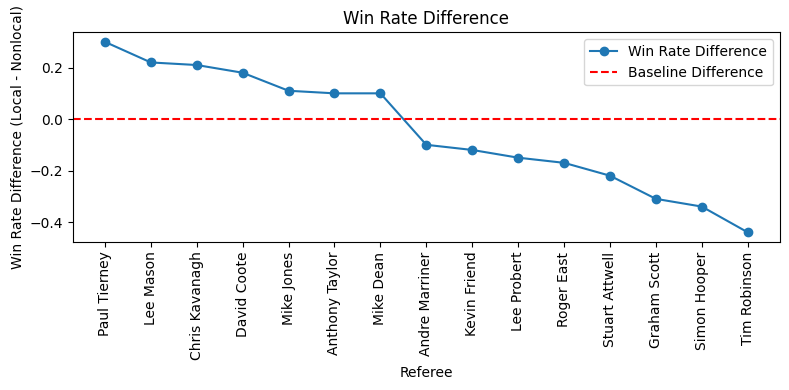

In [ ]:
combined_df['Win_Rate_Diff'] = combined_df['Win Rate_local'] - combined_df['Win Rate_nonlocal']
combined_df = combined_df.sort_values(by='Win_Rate_Diff', ascending=False)

# plt.figure(figsize=(10, 5))
# sns.barplot(x='Win_Rate_Diff', y='Referee', data=combined_df, palette='coolwarm', legend=False)
# plt.title("Difference in Win Rate")
# plt.xlabel("Win Rate Difference")
# plt.ylabel("Referee")
# plt.show()

plt.figure(figsize=(8,4))
plt.plot(combined_df['Referee'], combined_df['Win_Rate_Diff'], marker='o', linestyle='-', label='Win Rate Difference')

plt.axhline(0, color='red', linestyle='--', label='Baseline Difference')
plt.xlabel('Referee')
plt.ylabel('Win Rate Difference (Local - Nonlocal)')
plt.title('Win Rate Difference')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

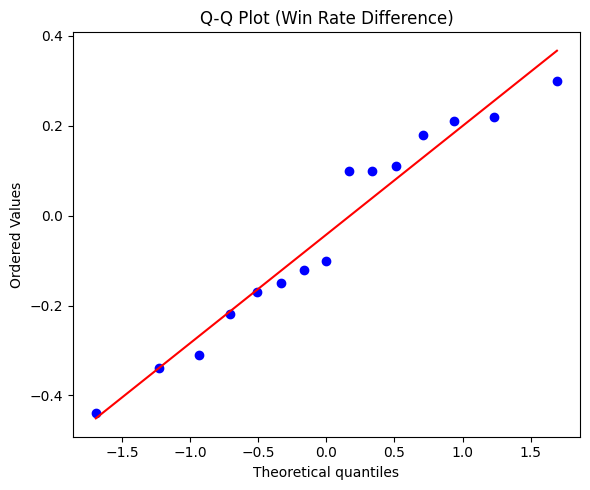

In [ ]:
import scipy.stats as stats

data = combined_df['Win_Rate_Diff'].dropna()
plt.figure(figsize=(6,5))

stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot (Win Rate Difference)")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import wilcoxon

stat, p_val = wilcoxon(combined_df['Win_Rate_Diff'].dropna())
print(f"Wilcoxon statistic = {stat:.3f}, p-value = {p_val:.3f}")

Wilcoxon statistic = 47.500, p-value = 0.524


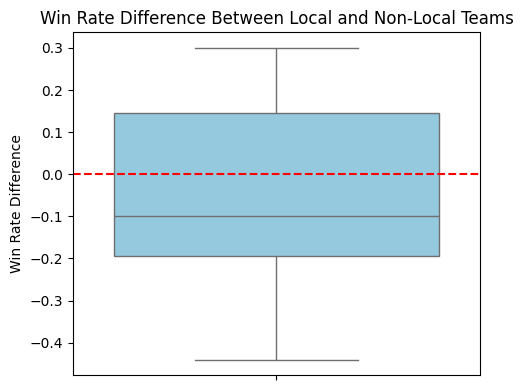

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(y=combined_df['Win_Rate_Diff'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Win Rate Difference Between Local and Non-Local Teams")
plt.ylabel("Win Rate Difference")
plt.tight_layout()
plt.show()

In [ ]:
card_df = df.copy()

match_stats = []

for (home_idx, away_idx) in matched_pairs:
    home_record = card_df.loc[home_idx]
    away_record = card_df.loc[away_idx]

    referee = home_record['Referee']
    referee_hometown = home_record['Referee Hometown']

    local_record = None
    nonlocal_record = None
    if (home_record['Team Detailed Region'] == referee_hometown) and (away_record['Team Detailed Region'] != referee_hometown):
        local_record = home_record
        nonlocal_record = away_record
    elif (away_record['Team Detailed Region'] == referee_hometown) and (home_record['Team Detailed Region'] != referee_hometown):
        local_record = away_record
        nonlocal_record = home_record
    else:
        continue

    local_crds = local_record['CrdY'] + local_record['2CrdY'] + local_record['CrdR']
    nonlocal_crds = nonlocal_record['CrdY'] + nonlocal_record['2CrdY'] + nonlocal_record['CrdR']

    local_fls = local_record['Fls (fouls committed)']
    nonlocal_fls = nonlocal_record['Fls (fouls committed)']

    local_ratio = round(local_crds / local_fls, 2) if local_fls else np.nan
    nonlocal_ratio = round(nonlocal_crds / nonlocal_fls, 2) if nonlocal_fls else np.nan

    match_stats.append({
        'Referee': referee,
        'Diff_Cards': local_crds - nonlocal_crds,
        'Diff_Fouls': local_fls - nonlocal_fls,
        'Diff_Ratio': local_ratio - nonlocal_ratio
    })

match_stats_df = pd.DataFrame(match_stats)
print(match_stats_df.head())

          Referee  Diff_Cards  Diff_Fouls  Diff_Ratio
0  Anthony Taylor          -3         -12        0.39
1  Chris Kavanagh          -2          -2       -0.16
2    Paul Tierney           0           3       -0.03
3  Anthony Taylor          -2         -11       -0.10
4  Anthony Taylor           1          -1        0.18


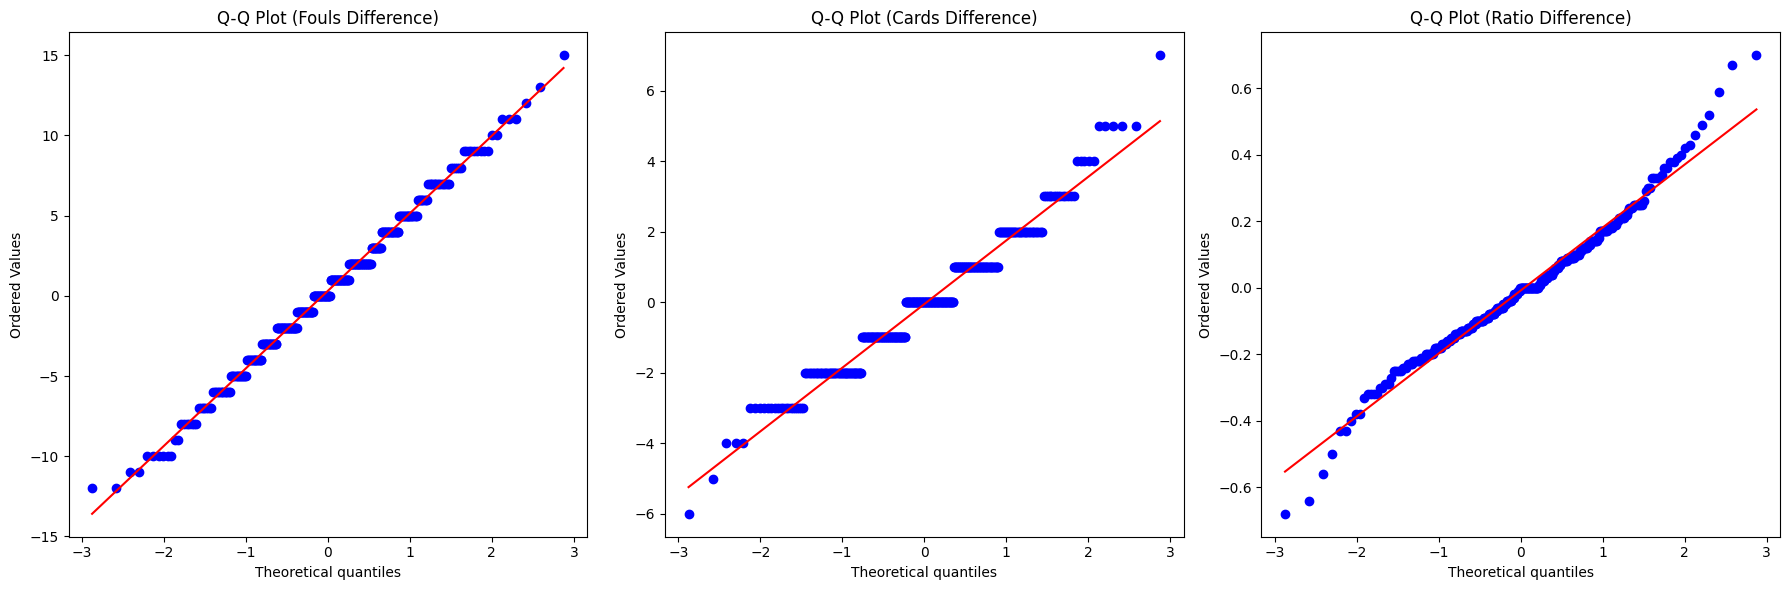

In [ ]:
fls = match_stats_df['Diff_Fouls'].dropna()
crds = match_stats_df['Diff_Cards'].dropna()
ratio = match_stats_df['Diff_Ratio'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

stats.probplot(fls, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot (Fouls Difference)")

stats.probplot(crds, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot (Cards Difference)")

stats.probplot(ratio, dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot (Ratio Difference)")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_1samp

print("t-tests:")
t_stat_f, p_val_f = ttest_1samp(match_stats_df['Diff_Fouls'].dropna(), 0)
print(f"Diff_Fouls: t-statistic = {t_stat_f:.3f}, p-value = {p_val_f:.3f}")

t_stat_c, p_val_c = ttest_1samp(match_stats_df['Diff_Cards'].dropna(), 0)
print(f"Diff_Cards: t-statistic = {t_stat_c:.3f}, p-value = {p_val_c:.3f}")

t_stat_r, p_val_r = ttest_1samp(match_stats_df['Diff_Ratio'].dropna(), 0)
print(f"Diff_Ratio: t-statistic = {t_stat_r:.3f}, p-value = {p_val_r:.3f}")

t-tests:
Diff_Fouls: t-statistic = 1.178, p-value = 0.240
Diff_Cards: t-statistic = -0.562, p-value = 0.575
Diff_Ratio: t-statistic = -0.775, p-value = 0.439


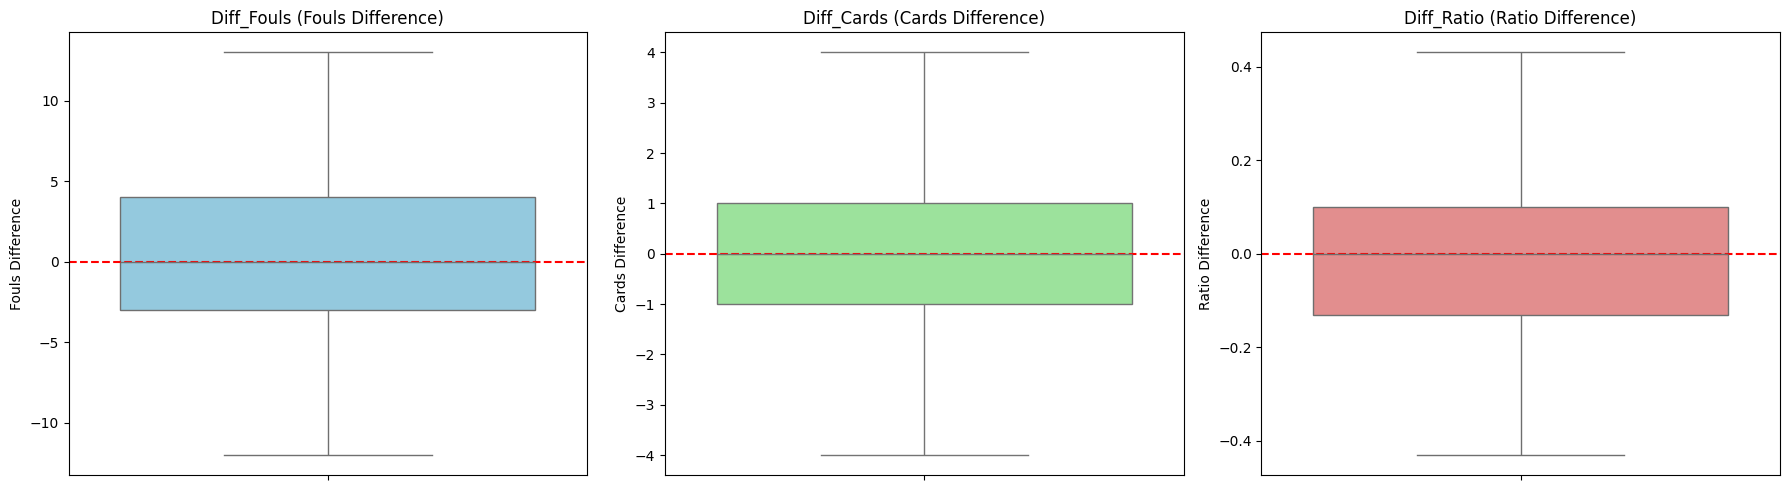

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=match_stats_df['Diff_Fouls'].dropna(), color='skyblue', showfliers=False, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_title("Diff_Fouls (Fouls Difference)")
axs[0].set_ylabel("Fouls Difference")

sns.boxplot(y=match_stats_df['Diff_Cards'].dropna(), color='lightgreen', showfliers=False, ax=axs[1])
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title("Diff_Cards (Cards Difference)")
axs[1].set_ylabel("Cards Difference")

sns.boxplot(y=match_stats_df['Diff_Ratio'].dropna(), color='lightcoral', showfliers=False, ax=axs[2])
axs[2].axhline(0, color='red', linestyle='--')
axs[2].set_title("Diff_Ratio (Ratio Difference)")
axs[2].set_ylabel("Ratio Difference")

plt.tight_layout()
plt.show()

In [ ]:
extra_time_df = df.copy()

extra_time_stats = []

for (home_idx, away_idx) in matched_pairs:
  home_record = extra_time_df.loc[home_idx]
  away_record = extra_time_df.loc[away_idx]

  referee = home_record['Referee']
  referee_hometown = home_record['Referee Hometown']

  local_record = None
  nonlocal_record = None

  if (home_record['Team Detailed Region'] == referee_hometown) and (away_record['Team Detailed Region'] != referee_hometown):
    local_record = home_record
    nonlocal_record = away_record
  elif (away_record['Team Detailed Region'] == referee_hometown) and (home_record['Team Detailed Region'] != referee_hometown):
    local_record = away_record
    nonlocal_record = home_record
  else:
    continue

  if local_record.equals(home_record):
    local_extra_goal = home_record['Second Extra Team Goal']
    nonlocal_extra_goal = home_record['Second Extra Opponent Goal']
  else:
    local_extra_goal = away_record['Second Extra Team Goal']
    nonlocal_extra_goal = away_record['Second Extra Opponent Goal']

  diff_extra_goals = local_extra_goal - nonlocal_extra_goal
  extra_time = home_record['Second Extra Time']

  local_regular_goal = local_record['GF (goals for)'] - local_extra_goal
  nonlocal_regular_goal = nonlocal_record['GF (goals for)'] - nonlocal_extra_goal
  regular_goal_diff = local_regular_goal - nonlocal_regular_goal

  if regular_goal_diff > 0:
    outcome = "Leading"
  elif regular_goal_diff == 0:
    outcome = "Drawing"
  else:
    outcome = "Trailing"

  final_result = local_record['Result']

  if outcome != "Leading" and final_result == "W":
    outcome_change = True
  elif outcome == "Leading" and final_result != "W":
    outcome_change = True
  else:
    outcome_change = False

  extra_time_stats.append({
      'Referee': referee,
      'Match': (home_record['Team'], away_record['Team']),
      'Regular_Time_Outcome': outcome,
      'Final_Result': final_result,
      'Outcome_Changed': outcome_change,
      'Regular_Goal_Difference': regular_goal_diff,
      'Extra_Time': extra_time,
      'Local_Extra_Goal': local_extra_goal,
      'Nonlocal_Extra_Goal': nonlocal_extra_goal,
      'Extra_Goal_Difference': diff_extra_goals,
  })

extra_time_df = pd.DataFrame(extra_time_stats)
print(extra_time_df.head())

          Referee                                 Match Regular_Time_Outcome  \
0  Anthony Taylor  (Manchester City, Nottingham Forest)              Leading   
1  Chris Kavanagh          (Manchester City, Liverpool)              Drawing   
2    Paul Tierney     (Manchester City, Crystal Palace)              Leading   
3  Anthony Taylor            (Manchester City, Arsenal)              Drawing   
4  Anthony Taylor          (Arsenal, Manchester United)              Drawing   

  Final_Result  Outcome_Changed  Regular_Goal_Difference  Extra_Time  \
0            W            False                      2.0           8   
1            D            False                      0.0           9   
2            D             True                      1.0           8   
3            D            False                      0.0           6   
4            L            False                      0.0          12   

   Local_Extra_Goal  Nonlocal_Extra_Goal  Extra_Goal_Difference  
0                 0 

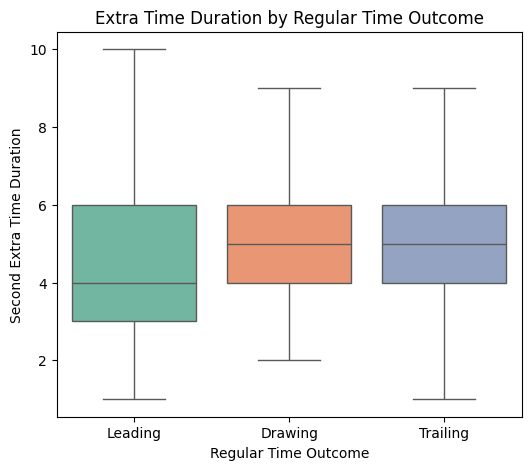

Group means of Extra Time Duration:
Regular_Time_Outcome
Drawing     5.32
Leading     4.63
Trailing    5.17
Name: Extra_Time, dtype: float64


In [ ]:
from scipy.stats import f_oneway, kruskal

plt.figure(figsize=(6,5))
sns.boxplot(x='Regular_Time_Outcome', y='Extra_Time', data=extra_time_df, palette="Set2", showfliers=False)

plt.title("Extra Time Duration by Regular Time Outcome")
plt.xlabel("Regular Time Outcome")
plt.ylabel("Second Extra Time Duration")
plt.show()

group_means = extra_time_df.groupby('Regular_Time_Outcome')['Extra_Time'].mean().round(2)
print("Group means of Extra Time Duration:")
print(group_means)

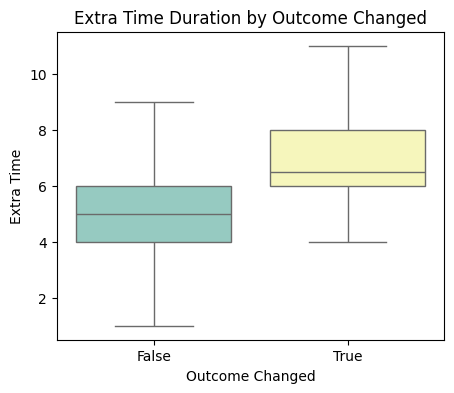

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Outcome_Changed', y='Extra_Time', data=extra_time_df, palette="Set3", showfliers=False)
plt.title("Extra Time Duration by Outcome Changed")
plt.xlabel("Outcome Changed")
plt.ylabel("Extra Time")
plt.show()

In [ ]:
from scipy.stats import kruskal

group_leading = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Leading']['Extra_Time'].dropna()
group_drawing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Drawing']['Extra_Time'].dropna()
group_trailing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Trailing']['Extra_Time'].dropna()

stat_kruskal, p_kruskal = kruskal(group_leading, group_drawing, group_trailing)

print(f"Kruskal-Wallis test: stat = {stat_kruskal:.3f}, p = {p_kruskal:.3f}")

Kruskal-Wallis test: stat = 10.363, p = 0.006


In [ ]:
!pip install scikit-posthocs

In [ ]:
from scikit_posthocs import posthoc_dunn

p_dunn = (posthoc_dunn([group_leading, group_drawing, group_trailing], p_adjust="holm")).round(2)

print("Dunn's test p-values:")
print(p_dunn)

Dunn's test p-values:
      1     2     3
1  1.00  0.02  0.02
2  0.02  1.00  0.74
3  0.02  0.74  1.00


Optimization terminated successfully.
         Current function value: 0.159148
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_Outcome_Changed   No. Observations:                  342
Model:                          Logit   Df Residuals:                      340
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                 0.06880
Time:                        20:23:55   Log-Likelihood:                -54.429
converged:                       True   LL-Null:                       -58.450
Covariance Type:            nonrobust   LLR p-value:                  0.004569
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7850      0.676     -7.082      0.000      -6.109      -3.461
Extra_Time     0.2859      0.

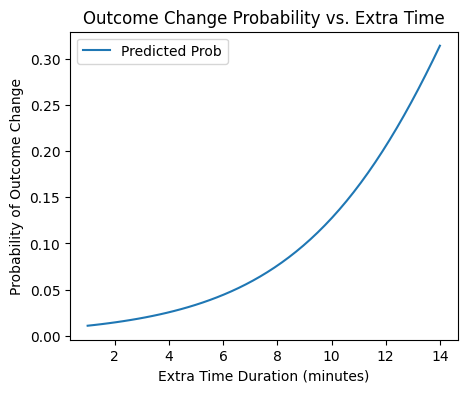

In [ ]:
import statsmodels.formula.api as smf

extra_time_df['is_Outcome_Changed'] = extra_time_df['Outcome_Changed'].astype(int)

model_simple = smf.logit("is_Outcome_Changed ~ Extra_Time", data=extra_time_df).fit()
print(model_simple.summary())

time_range = np.linspace(extra_time_df['Extra_Time'].min(), extra_time_df['Extra_Time'].max(), 50)
df_pred = pd.DataFrame({'Extra_Time': time_range})
df_pred['pred_prob'] = model_simple.predict(df_pred)

plt.figure(figsize=(5,4))
plt.plot(df_pred['Extra_Time'], df_pred['pred_prob'], label="Predicted Prob")
plt.xlabel("Extra Time Duration (minutes)")
plt.ylabel("Probability of Outcome Change")
plt.title("Outcome Change Probability vs. Extra Time")
plt.legend()
plt.show()

In [ ]:
xg_df = df.copy()

xg_df = xg_df.dropna(subset=['xG (expected goals)'])

clean_matched_pairs = []

for (home_idx, away_idx) in matched_pairs:
    if home_idx in xg_df.index and away_idx in xg_df.index:
        home_xg = xg_df.loc[home_idx]['xG (expected goals)']
        away_xg = xg_df.loc[away_idx]['xG (expected goals)']
        if pd.notnull(home_xg) and pd.notnull(away_xg):
            clean_matched_pairs.append((home_idx, away_idx))

print("Number of matched pairs after cleaning:", len(clean_matched_pairs))

Number of matched pairs after cleaning: 2660


In [ ]:
xg_stats = []

for (home_idx, away_idx) in clean_matched_pairs:
  home_record = xg_df.loc[home_idx]
  away_record = xg_df.loc[away_idx]

  referee = home_record['Referee']
  referee_hometown = home_record['Referee Hometown']

  local_record = None
  nonlocal_record = None
  if (home_record['Team Detailed Region'] == referee_hometown) and (away_record['Team Detailed Region'] != referee_hometown):
    local_record = home_record
    nonlocal_record = away_record
  elif (away_record['Team Detailed Region'] == referee_hometown) and (home_record['Team Detailed Region'] != referee_hometown):
    local_record = away_record
    nonlocal_record = home_record
  else:
    continue

  local_xg = local_record['xG (expected goals)']
  nonlocal_xg = nonlocal_record['xG (expected goals)']
  diff_xg = local_xg - nonlocal_xg

  xg_stats.append({
      'Referee': referee,
      'Local_xG': local_xg,
      'Nonlocal_xG': nonlocal_xg,
      'Diff_xG': diff_xg,
      'is_win': local_record['is_win']
  })

xg_stats_df = pd.DataFrame(xg_stats)
print(xg_stats_df.head())

          Referee  Local_xG  Nonlocal_xG  Diff_xG  is_win
0  Anthony Taylor       1.3          1.0      0.3       1
1  Chris Kavanagh       1.3          0.6      0.7       0
2    Paul Tierney       1.6          1.8     -0.2       0
3  Anthony Taylor       1.0          0.7      0.3       0
4  Anthony Taylor       0.9          2.3     -1.4       0


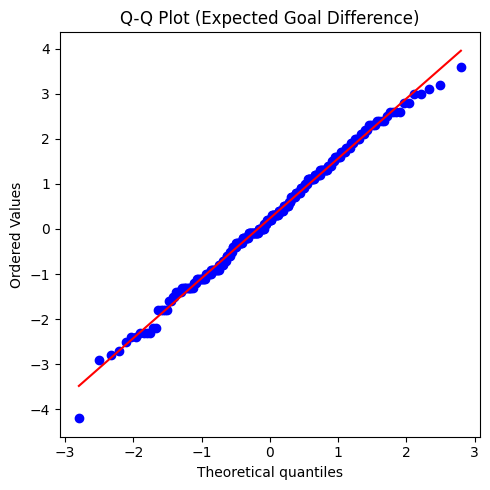

In [ ]:
xg = xg_stats_df['Diff_xG'].dropna()
plt.figure(figsize=(5,5))

stats.probplot(xg, dist="norm", plot=plt)
plt.title("Q-Q Plot (Expected Goal Difference)")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_1samp

t_stat, p_val = ttest_1samp(xg_stats_df['Diff_xG'].dropna(), 0)
print(f"t-test for Diff_xG: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-test for Diff_xG: t-statistic = 2.927, p-value = 0.004


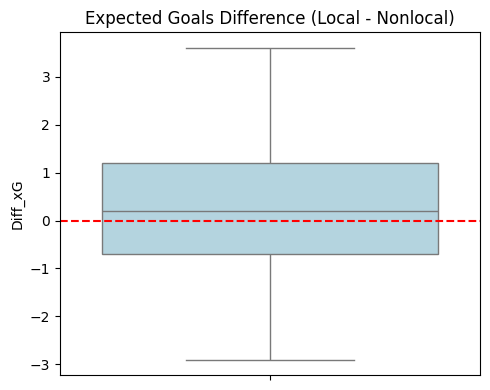

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(y='Diff_xG', data=xg_stats_df, color='lightblue', showfliers=False)
plt.title("Expected Goals Difference (Local - Nonlocal)")
plt.ylabel("Diff_xG")
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
xg_win = smf.logit("is_win ~ Diff_xG", data=xg_stats_df).fit()
print(xg_win.summary())

margeff = xg_win.get_margeff()
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.486167
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 is_win   No. Observations:                  268
Model:                          Logit   Df Residuals:                      266
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                  0.2938
Time:                        20:24:04   Log-Likelihood:                -130.29
converged:                       True   LL-Null:                       -184.50
Covariance Type:            nonrobust   LLR p-value:                 2.180e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6152      0.164     -3.758      0.000      -0.936      -0.294
Diff_xG        1.3281      0.

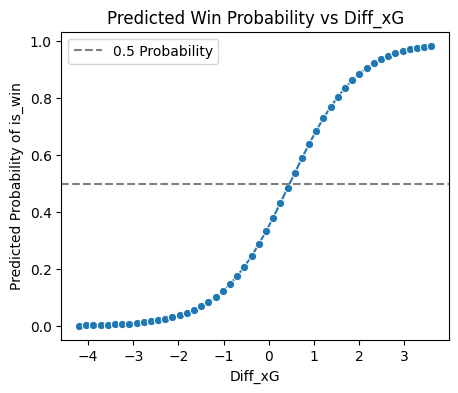

In [ ]:
diff_xg_range = np.linspace(xg_stats_df['Diff_xG'].min(), xg_stats_df['Diff_xG'].max())

df_pred = pd.DataFrame({'Diff_xG': diff_xg_range})

df_pred['pred_prob'] = xg_win.predict(df_pred)

plt.figure(figsize=(5,4))
sns.lineplot(x='Diff_xG', y='pred_prob', data=df_pred, marker="o")
plt.xlabel("Diff_xG")
plt.ylabel("Predicted Probability of is_win")
plt.title("Predicted Win Probability vs Diff_xG")
plt.axhline(0.5, color='gray', linestyle='--', label="0.5 Probability")
plt.legend()
plt.show()

In [ ]:
ref_xg = (xg_stats_df.groupby('Referee')['Diff_xG'].agg(['mean', 'std', 'count']).round(2))
ref_xg = ref_xg.rename(columns={'mean': 'Avg_Diff_xG', 'std': 'SD_Diff_xG', 'count': 'matches'})
ref_xg = ref_xg[ref_xg['matches'] > 5]

print("Per-Referee Average Diff_xG (Only Referees with >10 Matches):")
print(ref_xg.sort_values(by='Avg_Diff_xG', ascending=False).reset_index())

Per-Referee Average Diff_xG (Only Referees with >10 Matches):
           Referee  Avg_Diff_xG  SD_Diff_xG  matches
0        Mike Dean         1.16        1.26       13
1     Paul Tierney         0.84        1.06       41
2        Lee Mason         0.75        1.08       15
3   Chris Kavanagh         0.67        1.15       21
4      David Coote         0.48        1.20       11
5   Anthony Taylor         0.40        1.51       44
6   Andre Marriner         0.28        1.40       10
7     Simon Hooper         0.08        1.12       26
8      Lee Probert        -0.14        0.94       15
9       Roger East        -0.41        1.03       13
10    Tim Robinson        -0.42        1.11        6
11    Graham Scott        -0.48        1.23       31
12  Stuart Attwell        -0.50        1.50        9


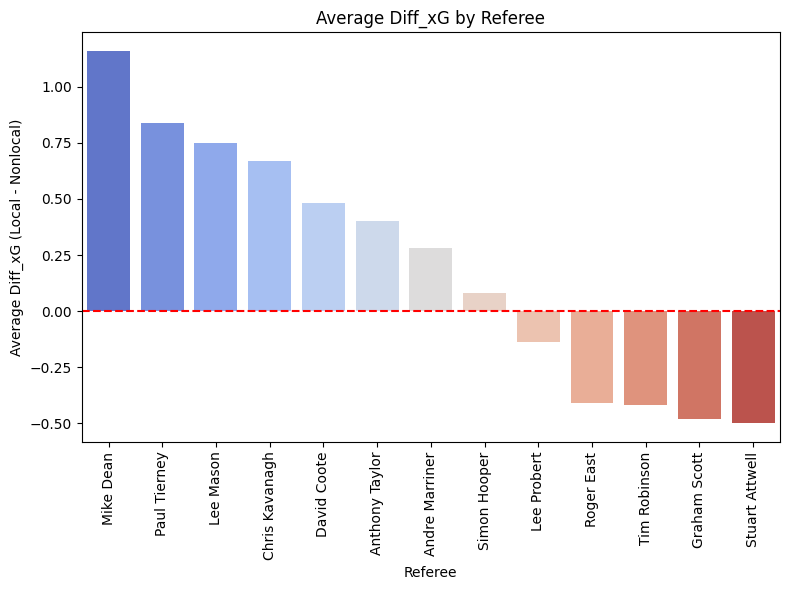

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='Referee', y='Avg_Diff_xG', data=ref_xg.sort_values(by='Avg_Diff_xG', ascending=False), palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Average Diff_xG (Local - Nonlocal)")
plt.title("Average Diff_xG by Referee")
plt.tight_layout()
plt.show()